# 프로젝트 : 폐렴 진단기 성능 개선

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from keras.callbacks import EarlyStopping
import keras
warnings.filterwarnings(action='ignore')

## STEP 1. 실험환경 Set-up

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=4),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

es = EarlyStopping(monitor='val_loss',patience=4,)
print(ROOT_PATH)

/aiffel/aiffel


### 필요한 함수를 정의합니다.

In [26]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def augment2(image,label):
    image = tf.image.random_flip_up_down(image)  # 랜덤하게 상하를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000,augmentation = True,BATCH_SIZE = 16):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    if augmentation:
        ds = ds.map(augment,num_parallel_calls=2)
        #ds = ds.map(augment2,num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds
#conv layer 생성 함수입니다.
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block
#dense layer 생성 함수입니다.
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block
# 모델 생성 함수
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## STEP 2. 데이터 준비

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

In [7]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115
Training images count: 4185
Validating images count: 1047


In [9]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [10]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## STEP 3. 데이터 시각화
* 좌우 반전및 상하 반전이 잘 적용되어 있습니다.

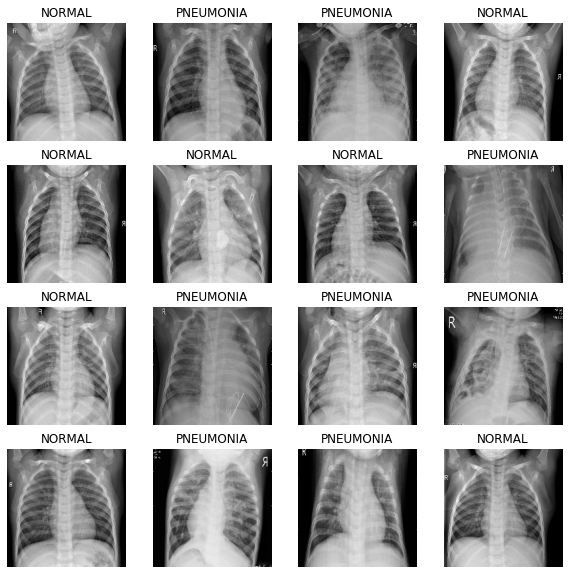

In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## STEP 4. CNN 모델링
* 다양한 모델을 훈련시키기 위해 전처리 과정과 훈련을 함수로 정의합니다.

In [39]:
# 데이터 imbalance 처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

1.955607476635514
0.6717495987158908


In [22]:
def model_build(BATCH_SIZE = 16,epochs = 25,optimizer = 'adam',rugularizer = 0,class_weight = class_weight,augment = True):
    train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
    val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
    
    train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    train_ds = prepare_for_training(train_ds,augmentation=augment,BATCH_SIZE=BATCH_SIZE)
    val_ds = prepare_for_training(val_ds,augmentation = augment,BATCH_SIZE=BATCH_SIZE)
    
    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)
    with tf.device('/GPU:0'):
        model = build_model()

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=METRICS
        )
    
    with tf.device('/GPU:0'):
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=epochs,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,
            #callbacks=es
        )
    #best_model = keras.models.load_model('best_model.h5')
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
    
    evaluation = {'loss' : loss, 'accuracy' : accuracy, 'precision' : precision, 'recall' : recall}
    return history,evaluation

In [14]:
def build_plot(history):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

## STEP 5. 데이터 imbalance처리
* 상단에서 정의 했으며, 미적용 결과는 훈련 과정을 통해 살펴보도록 하겠습니다.

## STEP 6. 모델 학습

### model1 학습 및 평가
* BATCH_SIZE = 16
* epochs = 5
* BN 적용
* Dropout 적용
* imbalance 처리

In [15]:
model1 = model_build(epochs=5)

Epoch 1/5
261/261 [==============================] - 54s 158ms/step - loss: 0.4412 - accuracy: 0.7692 - precision: 0.9401 - recall: 0.7368 - val_loss: 0.6080 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 41s 157ms/step - loss: 0.2418 - accuracy: 0.9030 - precision: 0.9760 - recall: 0.8915 - val_loss: 1.0787 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 42s 160ms/step - loss: 0.2331 - accuracy: 0.9116 - precision: 0.9698 - recall: 0.9096 - val_loss: 1.0390 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 42s 162ms/step - loss: 0.1873 - accuracy: 0.9253 - precision: 0.9775 - recall: 0.9208 - val_loss: 0.1227 - val_accuracy: 0.9519 - val_precision: 0.9917 - val_recall: 0.9424
Epoch 5/5
39/39 [==============================] - 5s 112ms/step - loss: 0.3371 - accuracy: 0.86

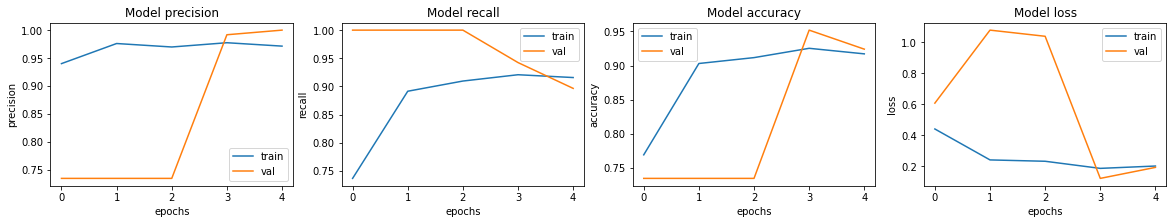

In [16]:
build_plot(model1[0])

### model2 학습 및 평가
* BATCH_SIZE = 16
* epochs = 5
* BN 미적용
* Dropout 적용
* imbalance 처리

In [24]:
model2 = model_build(epochs=5)

Epoch 1/5
261/261 [==============================] - 58s 191ms/step - loss: 0.6933 - accuracy: 0.4861 - precision: 0.7458 - recall: 0.4706 - val_loss: 0.6911 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 49s 188ms/step - loss: 0.6939 - accuracy: 0.5053 - precision: 0.7394 - recall: 0.5171 - val_loss: 0.6887 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 49s 187ms/step - loss: 0.6937 - accuracy: 0.5218 - precision: 0.7432 - recall: 0.5471 - val_loss: 0.7017 - val_accuracy: 0.2673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
261/261 [==============================] - 49s 189ms/step - loss: 0.6946 - accuracy: 0.4636 - precision: 0.7417 - recall: 0.4267 - val_loss: 0.6865 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 5/5
39/39 [==============================] - 4s 112ms/step - loss: 0.6972 - accura

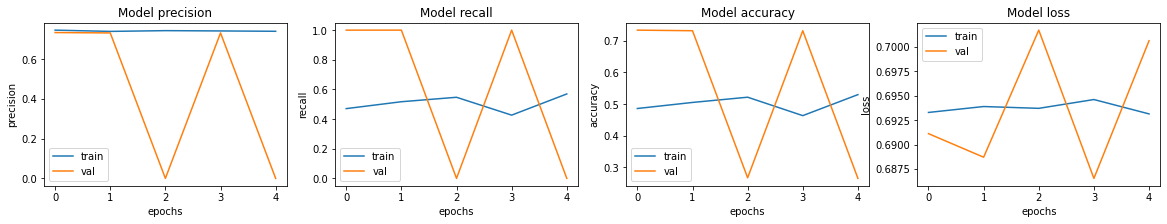

In [25]:
build_plot(model2[0])

### model3 학습 및 평가
* BATCH_SIZE = 16
* epochs = 5
* BN 적용
* Dropout 미적용
* imbalance 처리

In [28]:
model3 = model_build(epochs=5)

Epoch 1/5
261/261 [==============================] - 58s 188ms/step - loss: 0.2478 - accuracy: 0.8937 - precision: 0.9747 - recall: 0.8800 - val_loss: 0.6242 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 49s 188ms/step - loss: 0.1733 - accuracy: 0.9373 - precision: 0.9817 - recall: 0.9330 - val_loss: 1.5185 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 48s 185ms/step - loss: 0.1372 - accuracy: 0.9456 - precision: 0.9858 - recall: 0.9405 - val_loss: 0.2657 - val_accuracy: 0.8769 - val_precision: 0.8570 - val_recall: 0.9987
Epoch 4/5
261/261 [==============================] - 49s 188ms/step - loss: 0.1433 - accuracy: 0.9420 - precision: 0.9819 - recall: 0.9396 - val_loss: 0.2203 - val_accuracy: 0.8952 - val_precision: 0.8760 - val_recall: 0.9987
Epoch 5/5
39/39 [==============================] - 4s 111ms/step - loss: 0.4442 - accuracy: 0.85

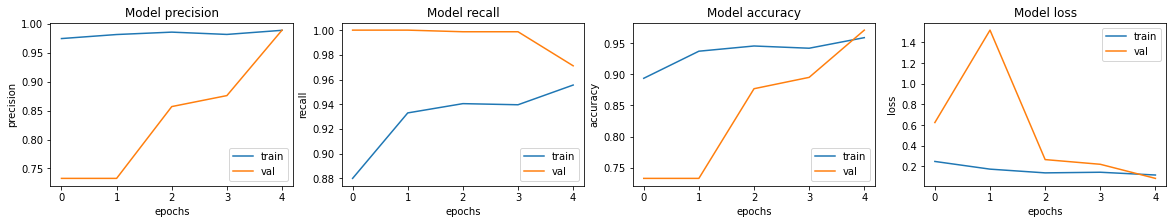

In [29]:
build_plot(model3[0])

### model4 학습 및 평가
* BATCH_SIZE = 32
* epochs = 5
* BN 적용
* Dropout 미적용
* imbalance 처리

In [30]:
model4 = model_build(BATCH_SIZE = 32,epochs=5)

Epoch 1/5
130/130 [==============================] - 57s 364ms/step - loss: 0.2038 - accuracy: 0.9161 - precision: 0.9784 - recall: 0.9073 - val_loss: 0.5818 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 47s 366ms/step - loss: 0.1403 - accuracy: 0.9490 - precision: 0.9846 - recall: 0.9465 - val_loss: 0.7510 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 48s 369ms/step - loss: 0.1162 - accuracy: 0.9534 - precision: 0.9846 - recall: 0.9521 - val_loss: 1.0287 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/5
130/130 [==============================] - 48s 373ms/step - loss: 0.1069 - accuracy: 0.9606 - precision: 0.9874 - recall: 0.9593 - val_loss: 1.3800 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/5
20/20 [==============================] - 4s 211ms/step - loss: 1.5895 - accuracy: 0.62

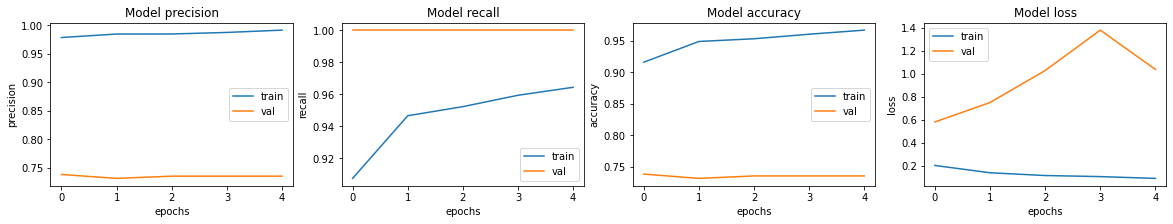

In [31]:
build_plot(model4[0])

### model5 학습 및 평가
* BATCH_SIZE = 8
* epochs = 5
* BN 적용
* Dropout 미적용
* imbalance 처리

In [32]:
model5 = model_build(BATCH_SIZE = 8,epochs=5)

Epoch 1/5
523/523 [==============================] - 60s 98ms/step - loss: 0.2955 - accuracy: 0.8721 - precision: 0.9644 - recall: 0.8600 - val_loss: 1.0804 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/5
523/523 [==============================] - 51s 97ms/step - loss: 0.2318 - accuracy: 0.9042 - precision: 0.9761 - recall: 0.8931 - val_loss: 0.1398 - val_accuracy: 0.9442 - val_precision: 0.9490 - val_recall: 0.9764
Epoch 3/5
523/523 [==============================] - 51s 97ms/step - loss: 0.2053 - accuracy: 0.9192 - precision: 0.9750 - recall: 0.9149 - val_loss: 0.1333 - val_accuracy: 0.9500 - val_precision: 0.9890 - val_recall: 0.9423
Epoch 4/5
523/523 [==============================] - 51s 97ms/step - loss: 0.1788 - accuracy: 0.9259 - precision: 0.9808 - recall: 0.9185 - val_loss: 0.1121 - val_accuracy: 0.9587 - val_precision: 0.9775 - val_recall: 0.9660
Epoch 5/5
78/78 [==============================] - 4s 52ms/step - loss: 0.6020 - accuracy: 0.8237 - 

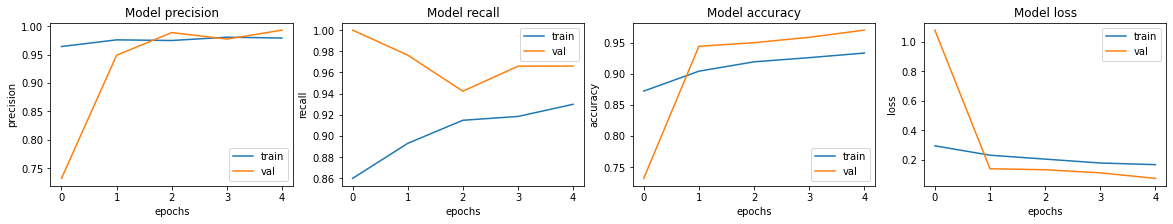

In [33]:
build_plot(model5[0])

### model6 학습 및 평가
* BATCH_SIZE = 16
* epochs = 5
* BN 적용
* Dropout 적용
* imbalance 미처리

In [35]:
model6 = model_build(epochs=5,class_weight = {0:1,1:1})

Epoch 1/5
261/261 [==============================] - 59s 190ms/step - loss: 0.2257 - accuracy: 0.9253 - precision: 0.9560 - recall: 0.9431 - val_loss: 0.7530 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 49s 187ms/step - loss: 0.1646 - accuracy: 0.9413 - precision: 0.9601 - recall: 0.9610 - val_loss: 1.1574 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 49s 188ms/step - loss: 0.1391 - accuracy: 0.9507 - precision: 0.9648 - recall: 0.9691 - val_loss: 0.1224 - val_accuracy: 0.9510 - val_precision: 0.9417 - val_recall: 0.9948
Epoch 4/5
261/261 [==============================] - 49s 188ms/step - loss: 0.1353 - accuracy: 0.9485 - precision: 0.9644 - recall: 0.9665 - val_loss: 0.0664 - val_accuracy: 0.9779 - val_precision: 0.9805 - val_recall: 0.9895
Epoch 5/5
39/39 [==============================] - 4s 107ms/step - loss: 1.0453 - accuracy: 0.71

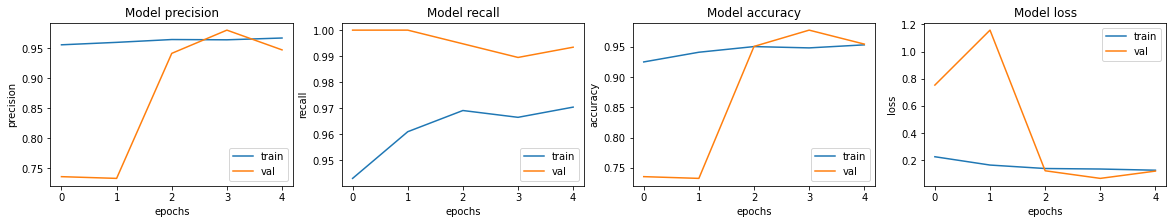

In [36]:
build_plot(model6[0])

## STEP 7. 결과 데이터 시각화

model 1 / batch : 16 , BN = true, Dropout = true
model 2 / BN = false
model 3 / batch : 16 , Dropout = false
model 4 / batch : 32 , Dropout = false
model 5 / batch : 8 ,Dropout = false
model 6 / batch : 16 ,Dropout = false,imbal = false


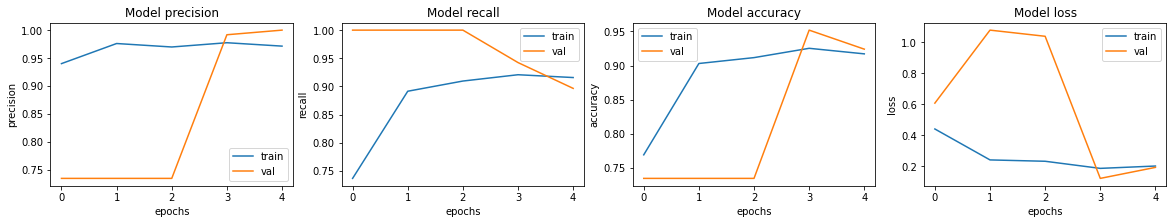

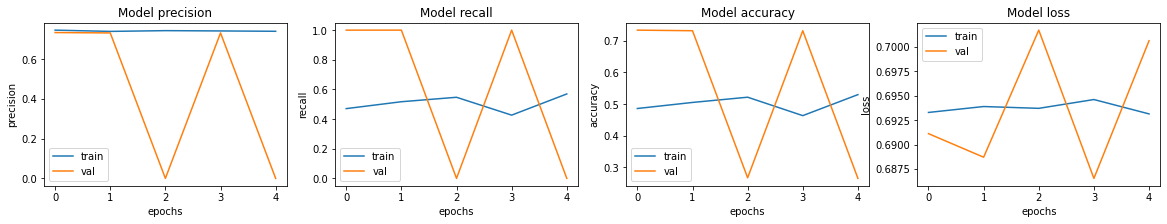

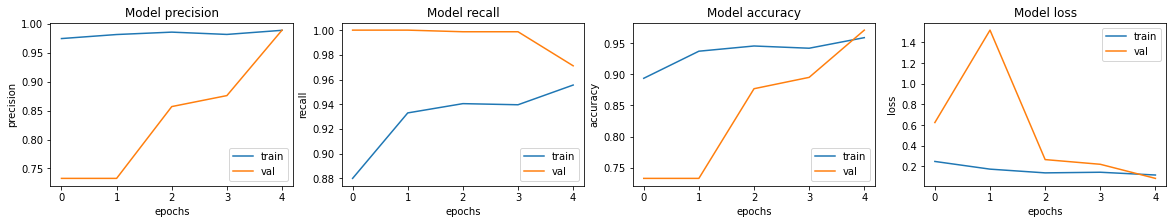

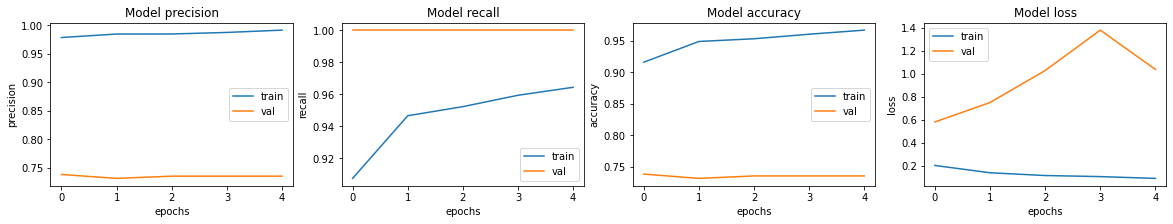

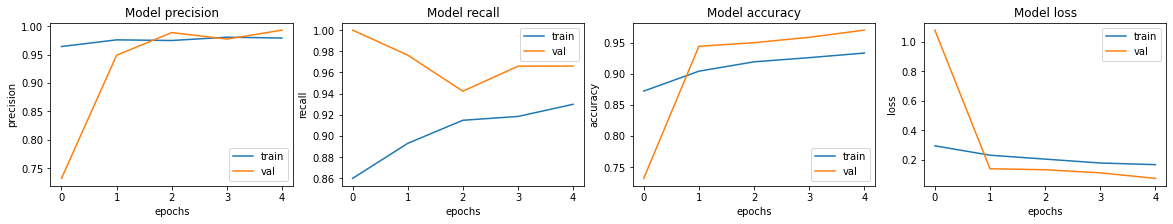

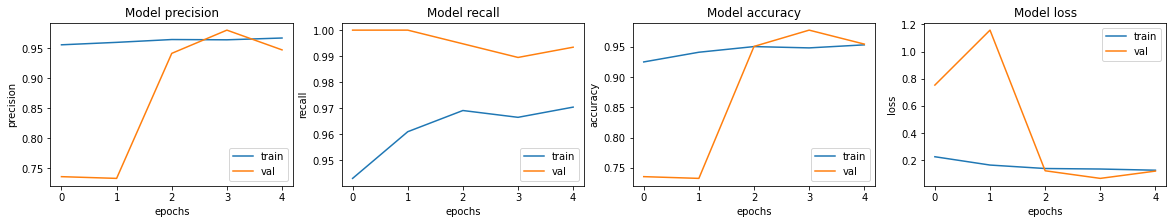

In [37]:
print("model 1 / batch : 16 , BN = true, Dropout = true")
build_plot(model1[0])
print("model 2 / BN = false")
build_plot(model2[0])
print("model 3 / batch : 16 , Dropout = false")
build_plot(model3[0])
print("model 4 / batch : 32 , Dropout = false")
build_plot(model4[0])
print("model 5 / batch : 8 ,Dropout = false")
build_plot(model5[0])
print("model 6 / batch : 16 ,Dropout = false,imbal = false")
build_plot(model6[0])

# 회고합시다.
* 데이터가 작다보니 bacth 크기를 적당히 잡아야 합니다.
* 데이터셋이 작아서 그런지 학습 과정이 굉장히 불안정했습니다. 때문에 eairy stopping을 하더라도 매우 감소된 정확도에서 종료될 수 있어 사용하기가 많이 힘듭니다.  사용하고자 한다면 best_model을 저장하는 ModelCheckpoint 함수를 함께 사용하는 것이 좋습니다.
* 배치 정규화를 사용하지 않는다면 학습과정이 매우 불안정해집니다.(2번 모델)
* 배치 정규화와 Dropout을 함께 사용한 모델(1번 모델)은 정확도는 86%로 높지만 recall이 낮습니다.
* 반면에 배치 정규화만을 사용한 모델(3번 모델)은 정확도는 85%로 비교적 낮지만 1번 모델에 비해 recall수치가 높아 가장 적합한 모델입니다.